### It's temporally used file so any modification will be fine ###

In [1]:
from MACalc import *
from MAUtil import *
from MAInit import *
from MAPost import *
from GASpyfuncs import *
import time
pd.set_option('display.max_columns', 100)
plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
figs = [20,50]
fign = [15,4]

In [5]:
atoms = init_query('Cu_111_u2_RPBE_no006_CO_n3_d3.traj','local')
get_coordination_matrix(atoms, expression='GNN')[0]

array([[0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 2., 0., 0., 2., 1., 0., 2., 1., 1., 0., 0.],
       [1., 1., 0., 1., 0., 2., 1., 1., 2., 0., 1., 2., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 2., 0., 0., 0., 1., 0., 2., 1., 0., 2., 1., 0., 3., 3.],
       [1., 0., 2., 1., 1., 0., 0., 1., 2., 1., 1., 2., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 2., 1., 0., 2., 1., 0., 0., 1., 0., 2., 0., 0., 3., 3.],
       [1., 1., 2., 0., 1., 2., 1., 1., 0., 1., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 2., 1., 0., 2., 1., 0., 2., 0., 0., 0., 1., 0., 3., 3.],
       [0., 1., 2., 1., 1., 2., 1., 0., 2., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0., 3., 0., 0., 3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0.

In [18]:
def get_edge_index_and_feature_and_filter(atoms, adsatoms):
    adseles = get_all_elements(adsatoms)
    baresurface, adsites = remove_adsorbate(atoms, adseles)
    b_mat, nads = get_coordination_matrix(atoms, expression='GNN')
    nads = len(adsites)

    features = []
#     ads_features.append(b_mat[-1,:-1])
    
    ads_info = b_mat[-nads:,:-nads]
    b_mat = b_mat[:-nads,:-nads]
    
    a = []
    b = []
    for i in range(len(b_mat)):
        for j in range(len(b_mat)):
            for k in range(int(b_mat[i,j])):
                a.append(i)
                b.append(j)
    edge_index = np.array([a,b])
    
    surf_filter = []
    
    i = 0
    for atom in baresurface:
        # atom info
        feature = []
        inst = element(atom.symbol)
        feature.append(inst.dipole_polarizability)
        feature.append(inst.density)
        feature.append(inst.lattice_constant)
        feature.append(inst.vdw_radius_uff)

    #     tmp.append(inst.group_id)
    #     tmp.append(inst.period)
        feature.append(inst.en_pauling)
        feature.append(inst.covalent_radius_cordero)
        feature.append(inst.nvalence())
    #     tmp.append(inst.ionenergies[1])
        feature.append(inst.electron_affinity)
    #     tmp.append('block')
    #     tmp.append(inst.atomic_volume)
    
        # adsorbate info
        ads_feature = [0,0,0] # # of T, B, H adsorbates
        ads_feature[0] += np.count_nonzero(ads_info[:,i]==1) # Top
        ads_feature[1] += np.count_nonzero(ads_info[:,i]==2) # Bridge
        ads_feature[2] += np.count_nonzero(ads_info[:,i]==3) # Hollow
        ads_feature[2] += np.count_nonzero(ads_info[:,i]==4) # Hollow
   
        feature = feature + ads_feature
        features.append(feature)

        # filter
        if atom.tag == 1:
            surf_filter.append(1)
        else:
            surf_filter.append(0)
        
        i += 1
    
    
    features = np.array(features)
    surf_filter = np.array(surf_filter)
    return edge_index, features, surf_filter

In [21]:
adsatoms = query('CO_RPBE.traj')
edge_index, features, surf_filter = get_edge_index_and_feature_and_filter(atoms, adsatoms)
print(edge_index)
print(features)
print(surf_filter)

[[ 0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
   3  3  3  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
   6  6  6  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8
   9  9  9 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11]
 [ 2  5  8  2  4  4  7  7  8 10 10 11  0  1  3  5  5  6  7  8  8 10 11 11
   2  5 11  1  1  5  7  7  8 10 10 11  0  2  2  3  4  7  8  8  9 10 11 11
   2  8 11  1  1  2  4  4  5  8 10 10  0  1  2  2  4  5  5  6  7  9 11 11
   5  8 11  1  1  2  4  4  5  7  7 11  1  2  2  3  4  5  5  6  8  8  9 10]]
[[ 46.5     8.96    3.61  349.5     1.9   132.     11.      1.235   0.
    0.      0.   ]
 [ 46.5     8.96    3.61  349.5     1.9   132.     11.      1.235   1.
    0.      0.   ]
 [ 46.5     8.96    3.61  349.5     1.9   132.     11.      1.235   0.
    0.      0.   ]
 [ 46.5     8.96    3.61  349.5     1.9   132.     11.      1.235   0.
    0.      0.   ]
 [ 46.5     8.96    3.61  349.5     1.9   132

In [5]:
symbol = ['Cu','Pt','Pd','Rh','Au','Ag','Ni','Al']
aaaa = []
for ele in symbol:
    tmp = []
    inst = element(ele)
    tmp.append(inst.dipole_polarizability)
    tmp.append(inst.density)
    tmp.append(inst.lattice_constant)
    tmp.append(inst.vdw_radius_uff)
    
#     tmp.append(inst.group_id)
#     tmp.append(inst.period)
    tmp.append(inst.en_pauling)
    tmp.append(inst.covalent_radius_cordero)
    tmp.append(inst.nvalence())
#     tmp.append(inst.ionenergies[1])
    tmp.append(inst.electron_affinity)
#     tmp.append('block')
#     tmp.append(inst.atomic_volume)
    aaaa.append(tmp)
    print(tmp)

[46.5, 8.96, 3.61, 349.5, 1.9, 132.0, 11, 1.235]
[48.0, 21.45, 3.92, 275.4, 2.2, 136.0, 10, 2.128]
[26.14, 12.02, 3.89, 289.9, 2.2, 139.0, 12, 0.562]
[66.0, 12.41, 3.8, 292.9, 2.28, 142.0, 9, 1.137]
[36.0, 19.3, 4.08, 329.3, 2.4, 136.0, 11, 2.30863]
[55.0, 10.5, 4.09, 314.8, 1.93, 145.0, 11, 1.3019999999999998]
[49.0, 8.902, 3.52, 283.4, 1.91, 124.0, 10, 1.156]
[57.8, 2.6989, 4.05, 449.9, 1.61, 121.0, 3, 0.43283]


In [6]:
aaaa = np.array(aaaa)

0 1


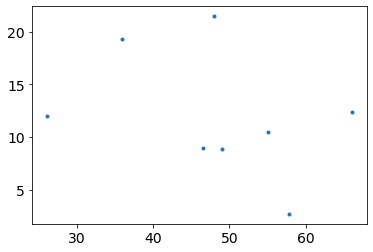

0 2


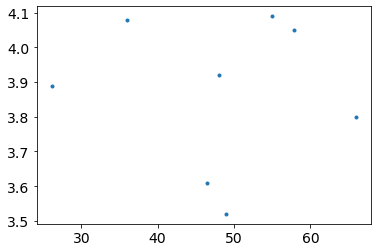

0 3


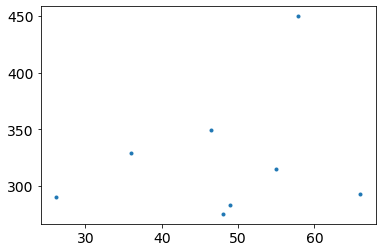

0 4


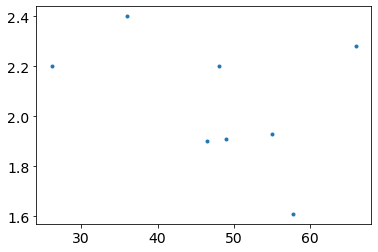

0 5


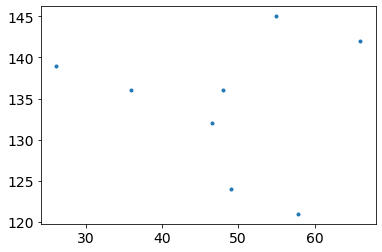

0 6


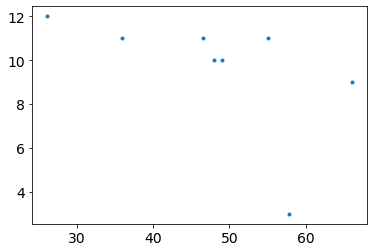

0 7


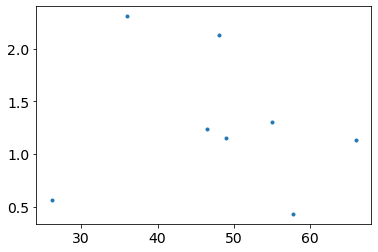

1 2


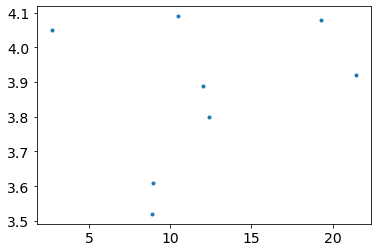

1 3


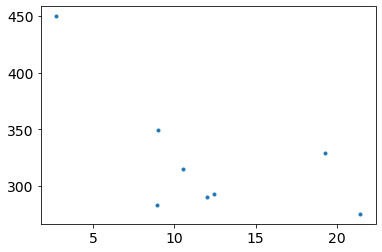

1 4


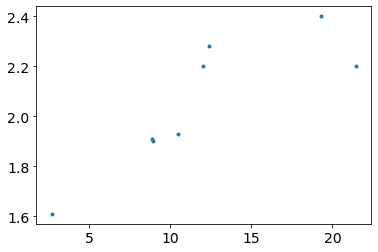

1 5


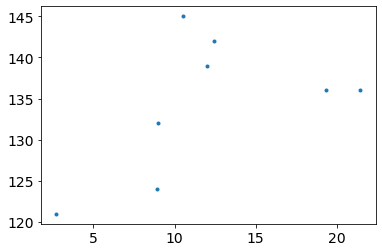

1 6


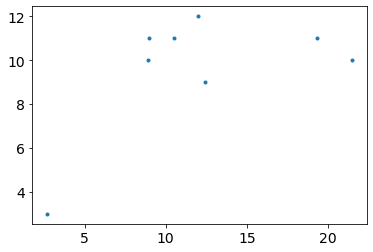

1 7


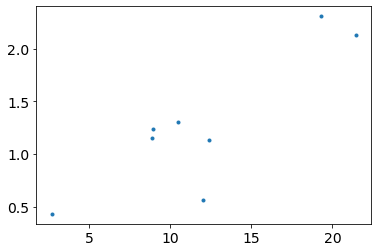

2 3


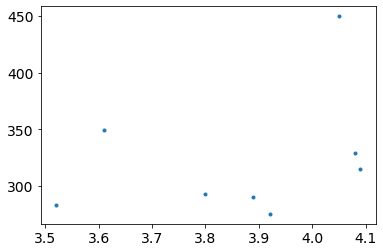

2 4


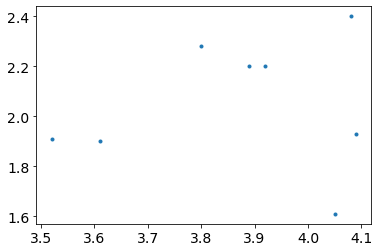

2 5


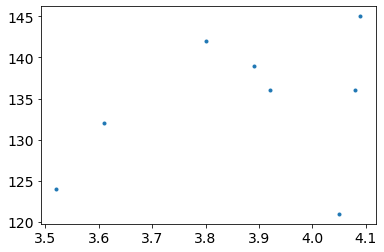

2 6


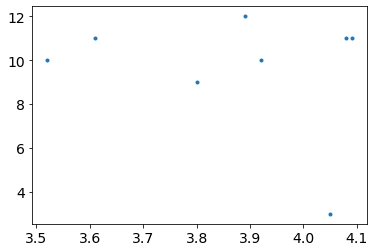

2 7


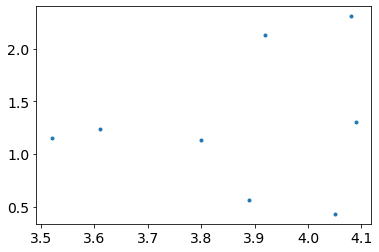

3 4


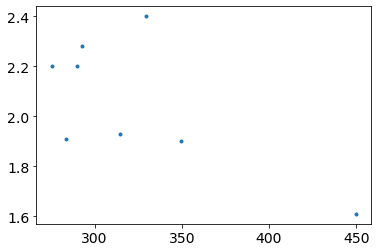

3 5


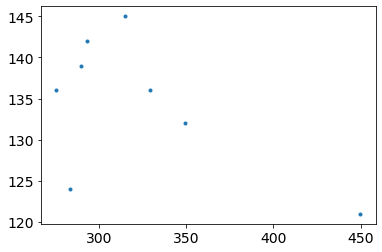

3 6


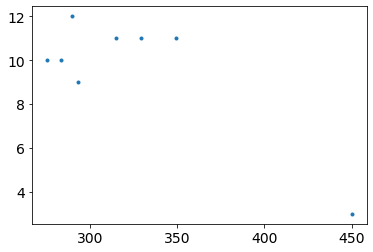

3 7


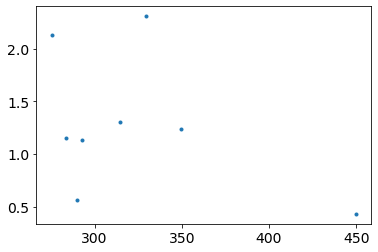

4 5


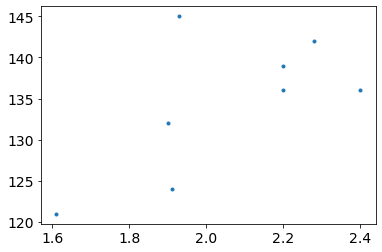

4 6


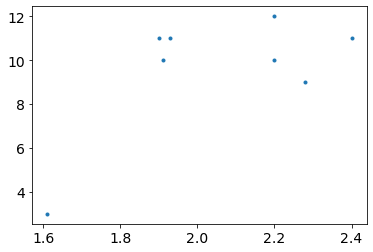

4 7


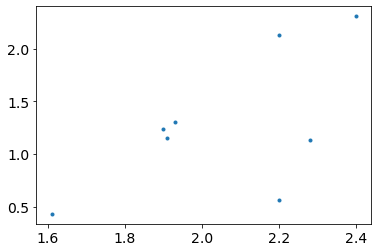

5 6


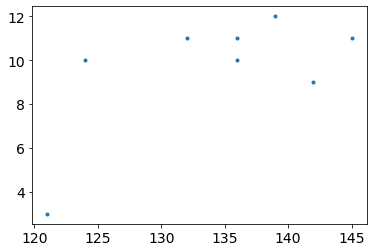

5 7


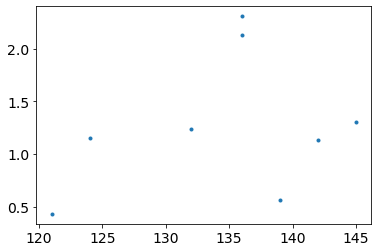

6 7


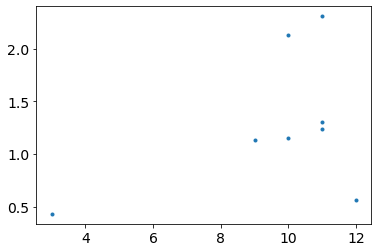

In [7]:
for i in range(len(aaaa[0])):
    for j in range(i+1,len(aaaa[0])):
        print(i,j)
        plt.plot(aaaa[:,i],aaaa[:,j],'.')
        plt.show()

In [8]:
import pandas as pd

In [9]:
bbbb = pd.DataFrame(aaaa)
bbbb.corr()

,0,1,2,3,4,5,6,7
0,1.000000,-0.345565,-0.046464,0.243134,-0.370607,-0.064014,-0.552692,-0.128613
1,-0.345565,1.000000,0.205536,-0.646468,0.850646,0.509031,0.571458,0.862076
2,-0.046464,0.205536,1.000000,0.331373,0.129084,0.330814,-0.230755,0.162810
3,0.243134,-0.646468,0.331373,1.000000,-0.677766,-0.565034,-0.797746,-0.416885
4,-0.370607,0.850646,0.129084,-0.677766,1.000000,0.637601,0.632231,0.618589
5,-0.064014,0.509031,0.330814,-0.565034,0.637601,1.000000,0.635411,0.300072
6,-0.552692,0.571458,-0.230755,-0.797746,0.632231,0.635411,1.000000,0.432963
7,-0.128613,0.862076,0.162810,-0.416885,0.618589,0.300072,0.432963,1.000000


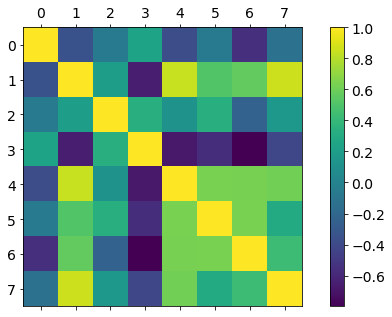

In [10]:
plt.figure(figsize=(10,5))
plt.matshow(bbbb.corr(), fignum=1)
plt.colorbar()
plt.show()